# Demo code to use Equinoctial Element for orbit propagation

In [19]:
import numpy as np
from scipy.integrate import odeint

import matplotlib.pyplot as plt

from src.utils import *
from src.propagation import *
from src.equinoctial import *

## Propagation

In [20]:
mu = 3.986004414498200e14 # (m^3/s^2)
Re = 6.378136460000000e6 # (m)

J_array = np.array([0.5]) # J2

In [21]:
r0 = np.array([[4681061.572749, 9522430.304714, 6121285.090357]]) # Initial position (m)
v0 = np.array([[868.9291807879, -3329.530572522, 4556.017503721]]) # Initial velocity (m/s)

kepl0 = ijk2keplerian(r0,v0,mu)
kepl0[0,1] = 0.3
y0 = keplerian2equinoctial(kepl0)

# Non-dimensionalization
L_non_dim = Re
T_non_dim = np.sqrt(L_non_dim**3 / mu)

y0[0,0] = y0[0,0] / L_non_dim # Convert semi-parameter to meters

In [22]:
# t = np.linspace(0, 864000.0, 28800+1) / T_non_dim # time (s) - 10 days
t = np.linspace(0, 518400.0, 17280+1) / T_non_dim # time (s) - 6 days

F_RSW = lambda y, J: zonal_RSW_equi(y, J, 1.0, 1.0) # Force in RSW coordinate (as a function of keplerian elements)
orbit_propagation = lambda y, t: (RSW2equi_A(y,1.0) @ F_RSW(y,J_array)+ RSW2equi_b(y,1.0))

sol = odeint(orbit_propagation, y0[0], t, rtol=1e-10)

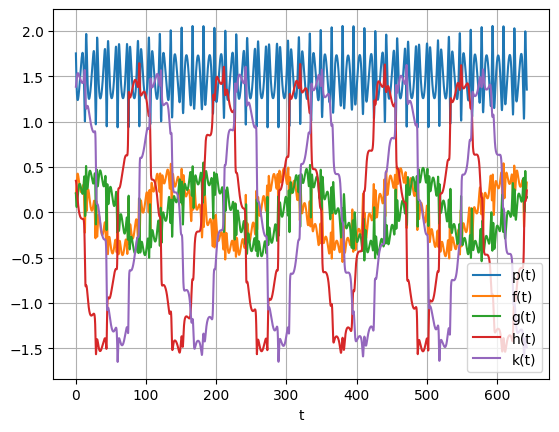

In [23]:
import matplotlib.pyplot as plt
plt.plot(t, sol[:, 0], label='p(t)')
plt.plot(t, sol[:, 1], label='f(t)')
plt.plot(t, sol[:, 2], label='g(t)')
plt.plot(t, sol[:, 3], label='h(t)')
plt.plot(t, sol[:, 4], label='k(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

## Export

In [24]:
import pandas as pd
from datetime import datetime, timedelta

sol_export = sol
sol_export[...,0] = sol_export[...,0] * L_non_dim # Convert semi-parameter back to meters

r_export,v_export = keplerian2ijk(equinoctial2keplerian(sol_export),mu)

t_export = t * T_non_dim # Convert time back to seconds

start_datetime = datetime(2017, 1, 1)
dt_export = [start_datetime + timedelta(seconds=float(sec)) for sec in t_export]

df_export = pd.DataFrame({
    'Time': dt_export,
    'rx': r_export[:, 0],
    'ry': r_export[:, 1],
    'rz': r_export[:, 2],
    'vx': v_export[:, 0],
    'vy': v_export[:, 1],
    'vz': v_export[:, 2]
})

df_export.to_csv('./data/Challenge1.csv', index=False)